In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

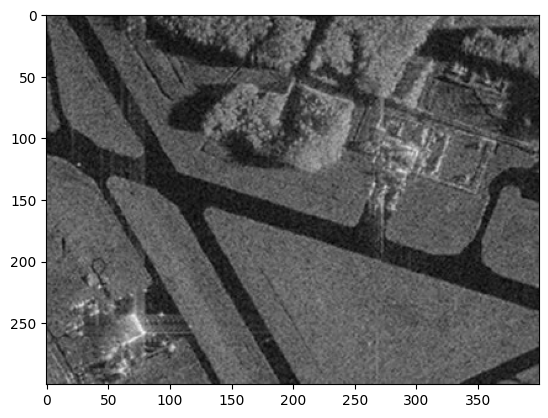

In [3]:
plt.imshow(image_gray, cmap="gray")

# Алгоритм разрастания регионов

In [4]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                            
    if abs(av_val - img[point]) <= T:
        return True
    
    return False
    

In [5]:
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask
        
    return mask*255
    

In [6]:
seed_point = (250,250)
mask = region_growing(image_gray,seed_point,homo_average,1, 10)

3
4
4
5
7
6
6
9
7
6
6
9
13
12
15
17
13
13
16
16
14
16
15
16
10
11
14
13
14
10
10
14
17
15
36
22
21
18
21
21
25
23
43
31
34
23
20
27
29
35
40
32
35
42
48
52
30
23
20
19
19
20
18
22
74
24
26
29
30
27
29
29
28
29
20
17
17
21
20
25
23
24
20
18
19
15
18
18
15
18
13
10
9
7
9
9
10
11
12
10
12
11
8
9
7
4
3
6
6
6
5
5
5
3
2
2
2
1
0


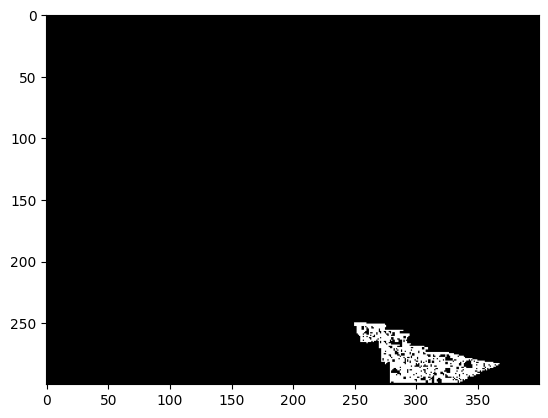

In [7]:
plt.imshow(mask, cmap="gray")

# K-means

In [8]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [9]:
flags = cv2.KMEANS_RANDOM_CENTERS

In [10]:
z = image_gray.reshape((-1,3))
# convert to np.float32
z = np.float32(z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

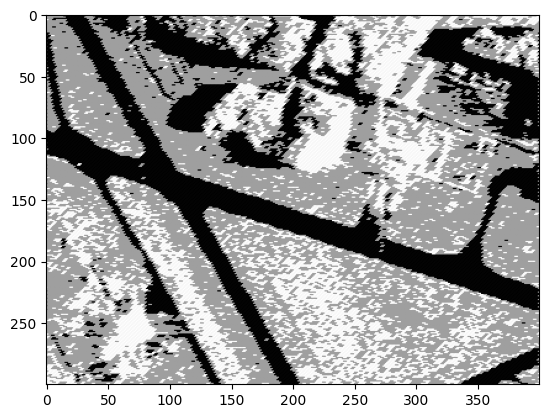

In [11]:
plt.imshow(res2, cmap="gray")

# Watershed+Distance transform

In [12]:
image = cv2.imread('oranges_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

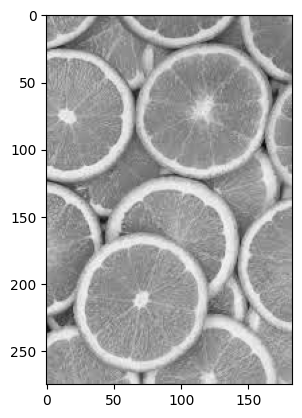

In [13]:
plt.imshow(image_gray, cmap="gray")

In [14]:
ret, thresh = cv2.threshold(image_gray,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

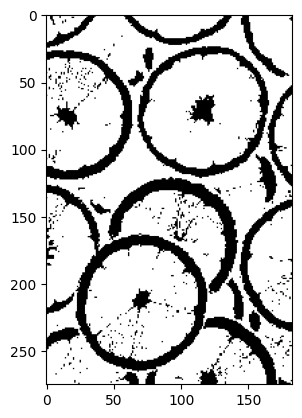

In [15]:
plt.imshow(thresh, cmap="gray")

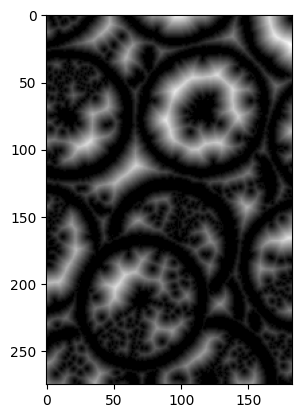

In [16]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
plt.imshow(dist, cmap="gray")

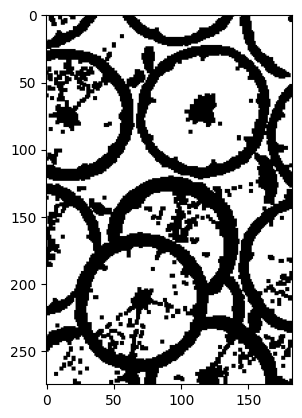

In [17]:
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY) 
plt.imshow(sure_fg, cmap="gray")

In [18]:
sure_fg = sure_fg.astype(np.uint8)

In [19]:
ret, markers = cv2.connectedComponents(sure_fg) 

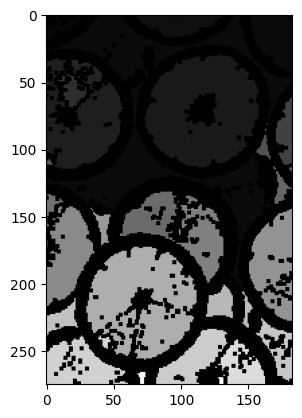

In [20]:
plt.imshow(markers, cmap="gray")

In [21]:
markers = cv2.watershed(image, markers)

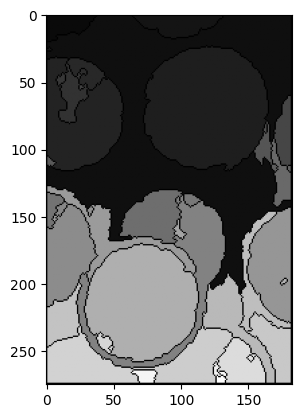

In [22]:
plt.imshow(markers, cmap="gray")

In [35]:
# ДЗ
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

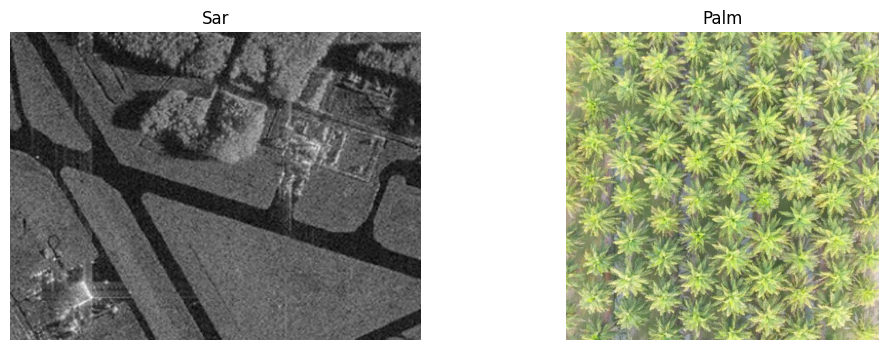

In [21]:
from skimage import io, color, filters, morphology, segmentation, feature, exposure, measure
from scipy import ndimage as ndi
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

sar_path = cv2.imread("sar_1.jpg")      
palm_path = cv2.imread("palm_1.jpg")     

sar = cv2.cvtColor(sar_path, cv2.COLOR_BGR2GRAY)
palm = cv2.cvtColor(palm_path, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1); 
plt.imshow(sar, cmap="gray"); 
plt.title("Sar"); 
plt.axis("off");

plt.subplot(1,2,2); 
plt.imshow(palm); 
plt.title("Palm");
plt.axis("off");

plt.show()

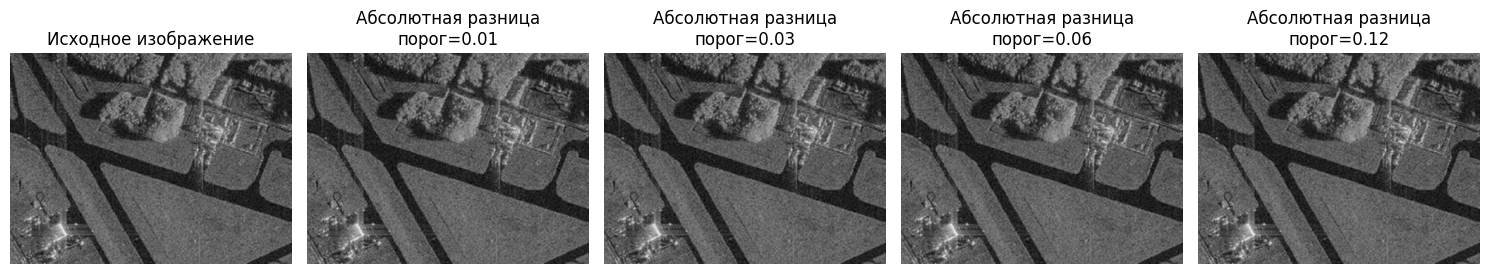

In [23]:
def segment_image(image, start_point, method='abs_diff', threshold=0.05, factor=1.5, neighbors=8, max_pixels=100000):
    
    height, width = image.shape
    segmentation_map = np.zeros_like(image, dtype=bool)
    checked_pixels = np.zeros_like(image, dtype=bool)
    pixel_queue = deque()
    pixel_queue.append(start_point)
    checked_pixels[start_point] = True
    region_intensities = [image[start_point]]
    segmentation_map[start_point] = True

    # Определение соседних позиций
    if neighbors == 8:
        offsets = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]
    else:
        offsets = [(-1,0),(0,-1),(0,1),(1,0)]

    while pixel_queue and len(region_intensities) < max_pixels:
        y, x = pixel_queue.popleft()
        region_mean = np.mean(region_intensities)
        region_std = np.std(region_intensities)
        
        for dy, dx in offsets:
            ny, nx = y+dy, x+dx
            if ny<0 or nx<0 or ny>=height or nx>=width: continue
            if checked_pixels[ny,nx]: continue
            
            checked_pixels[ny,nx] = True
            current_pixel = image[ny,nx]
            
            if method == 'abs_diff':
                condition = abs(current_pixel - region_mean) <= threshold
            elif method == 'adaptive':
                condition = abs(current_pixel - region_mean) <= max(factor*region_std, threshold/10.0)
            else:
                condition = False
                
            if condition:
                segmentation_map[ny,nx] = True
                region_intensities.append(current_pixel)
                pixel_queue.append((ny,nx))
                
    return segmentation_map

# Начальная точка (центр изображения)
start_point = (sar.shape[0]//2, sar.shape[1]//2)


threshold_values = [0.01, 0.03, 0.06, 0.12]
figure, axes = plt.subplots(1, len(threshold_values)+1, figsize=(15,4))
axes[0].imshow(sar, cmap="gray"); 
axes[0].set_title("Исходное изображение"); 
axes[0].axis("off")

for idx, threshold in enumerate(threshold_values):
    result_mask = segment_image(sar, start_point, method='abs_diff', threshold=threshold)
    axes[idx+1].imshow(sar, cmap="gray")
    axes[idx+1].imshow(np.ma.masked_where(~result_mask, result_mask), alpha=0.6)
    axes[idx+1].set_title(f"Абсолютная разница\nпорог={threshold}")
    axes[idx+1].axis("off")
    
plt.tight_layout()
plt.show()

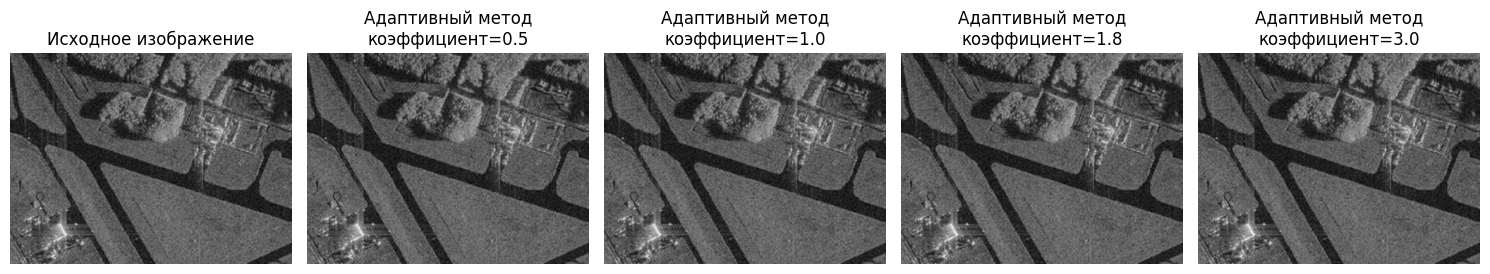

In [16]:
adaptive_coefficients = [0.5, 1.0, 1.8, 3.0]
figure, axes = plt.subplots(1, len(adaptive_coefficients) + 1, figsize=(15, 4))

axes[0].imshow(sar, cmap="gray")
axes[0].set_title("Исходное изображение")
axes[0].axis("off")

for index, coefficient in enumerate(adaptive_coefficients):
    segmentation_result = segment_image(
        sar, 
        start_point, 
        method='adaptive', 
        factor=coefficient, 
        threshold=0.02
    )
    
    axes[index + 1].imshow(sar, cmap="gray")
    axes[index + 1].imshow(
        np.ma.masked_where(~segmentation_result, segmentation_result), 
        alpha=0.6
    )
    axes[index + 1].set_title(f"Адаптивный метод\nкоэффициент={coefficient}")
    axes[index + 1].axis("off")

plt.tight_layout()
plt.show()

Определено пальмовых деревьев: 522


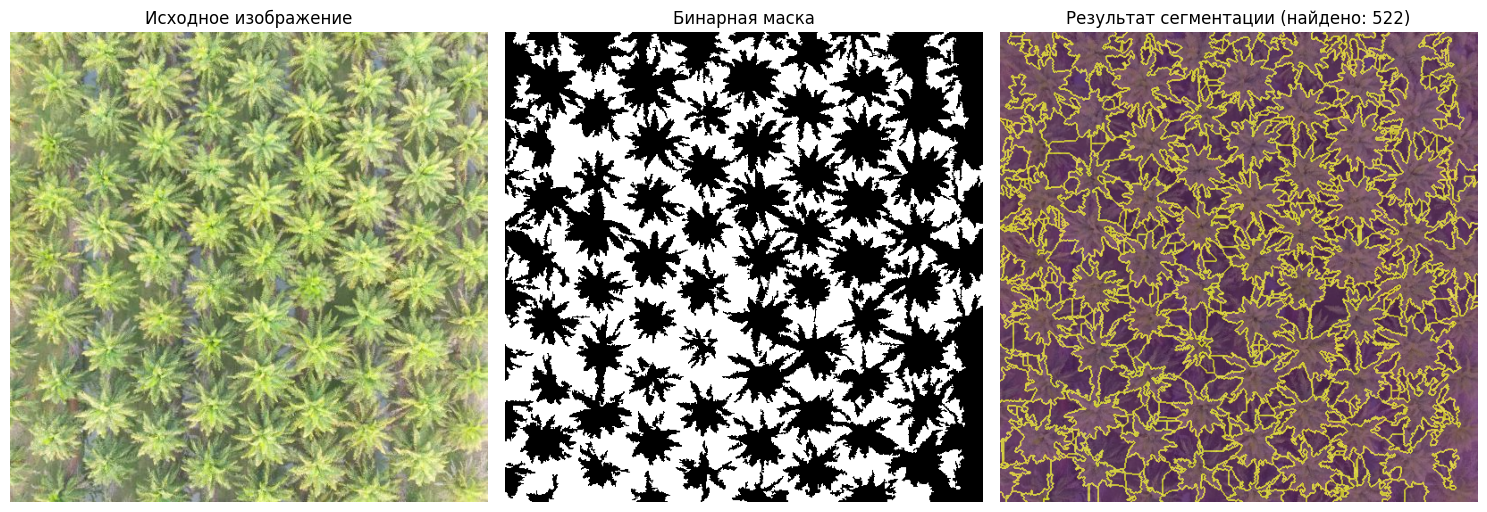

In [22]:
# Процедура бинаризации
threshold_value = filters.threshold_otsu(grayscale_palm)
binary_mask = grayscale_palm < threshold_value
binary_mask = morphology.remove_small_objects(binary_mask, min_size=200)
binary_mask = morphology.remove_small_holes(binary_mask, area_threshold=200)

# Построение карты расстояний
distance_map = ndi.distance_transform_edt(binary_mask)

# Обнаружение локальных максимумов
peak_coordinates = feature.peak_local_max(
    distance_map, 
    footprint=np.ones((15, 15)), 
    labels=binary_mask
)
seed_markers = np.zeros_like(distance_map, dtype=int)

for marker_id, (row, col) in enumerate(peak_coordinates, start=1):
    seed_markers[row, col] = marker_id

# Применение алгоритма водоразделов
segmentation_labels = segmentation.watershed(
    -distance_map, 
    seed_markers, 
    mask=binary_mask
)

palm_count = len(np.unique(segmentation_labels)) - 1
print("Определено пальмовых деревьев:", palm_count)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(palm)
axes[0].set_title("Исходное изображение")
axes[0].axis("off")

axes[1].imshow(binary_mask, cmap="gray")
axes[1].set_title("Бинарная маска")
axes[1].axis("off")

axes[2].imshow(palm)
axes[2].imshow(segmentation.find_boundaries(segmentation_labels), alpha=0.6)
axes[2].set_title(f"Результат сегментации (найдено: {palm_count})")
axes[2].axis("off")

plt.tight_layout()
plt.show()